In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

Width:  512 Height:  512


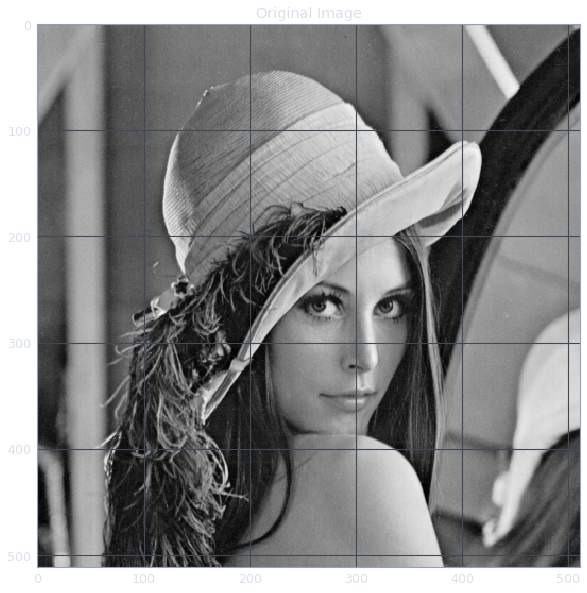

In [2]:
original_image = np.array(Image.open("lena512.bmp"))
height, width = original_image.shape

plt.figure(figsize=(10, 10))
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
print("Width: ", width, "Height: ", height)

### Convert Binary Image

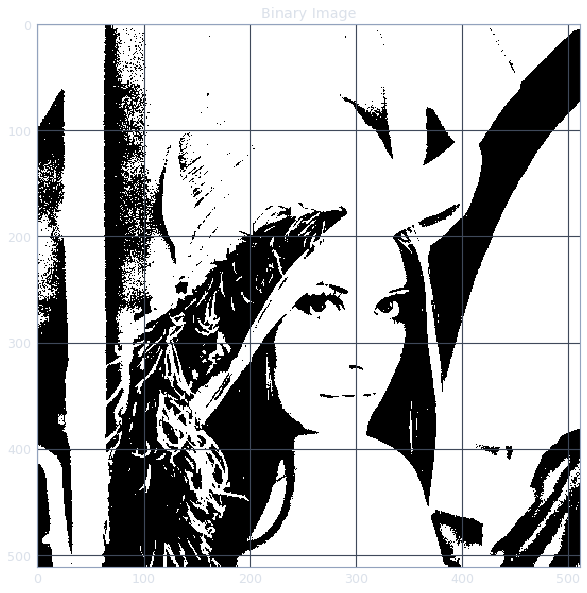

In [3]:
binary_image = np.where(original_image > 100, 1, 0)
plt.figure(figsize=(10, 10))
plt.title("Binary Image")
plt.imshow(binary_image, cmap='gray')

### Make noisy

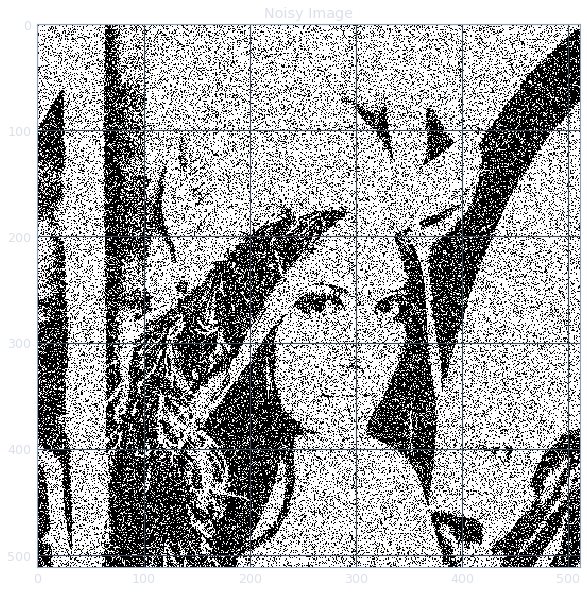

In [4]:
noisy_image = binary_image.copy()
noise = np.random.rand(*noisy_image.shape)
indices = np.where(noise < 0.2)
noisy_image[indices] = 1 - noisy_image[indices]
plt.figure(figsize=(10, 10))
plt.title("Noisy Image")
plt.imshow(noisy_image, cmap='gray')

In [5]:
class Denoise:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
        self.noisy_image = None
        self.height, self.width = None, None
        
        self.global_step = 0 

    @property
    def _SNR(self):
        return np.sum(np.abs(self.noisy_image - self.output)) / (self.height * self.width)
    
    def _neighbor(self, h, w):
        if h == 0 and w == 0:
            n = [(0, 1), (1, 0)]
        elif h == 0 and w == self.width - 1:
            n = [(0, self.width - 2), (1, self.width - 1)]
        elif h == self.height - 1 and w == 0:
            n = [(height - 1, 1), (height - 2, 0)]
        elif h == self.height - 1 and w == self.width - 1:
            n = [(height - 1, self.width - 2), (height - 2, self.width - 1)]
        elif h == 0:
            n = [(0, w - 1), (0, w + 1), (1, w)]
        elif h == self.height - 1:
            n = [(height - 1, w - 1), (height - 1, w + 1), (height - 2, w)]
        elif w == 0:
            n = [(h - 1, 0), (h + 1, 0), (h, 1)]
        elif w == self.width - 1:
            n = [(h - 1, self.width - 1), (h + 1, self.width - 1), (h, self.width - 2)]
        else:
            n = [(h - 1, w), (h + 1, w), (h, w - 1), (h, w + 1), (h - 1, w - 1), (h - 1, w + 1), (h + 1, w - 1),
                        (h + 1, w + 1)]
        return n
    
    def _delta(self, h, w):
        return 1 if h == w else 0
    
    def _cost(self, label, hidden_var, indices):
        return self.alpha * self._delta(label, hidden_var) + self.beta * sum(self._delta(label, self.noisy_image[i]) for i in indices)

    def __call__(self, noisy_image):
        self.noisy_image = noisy_image
        self.height, self.width = noisy_image.shape
        self.output = np.zeros_like(noisy_image)
        
        while self._SNR > 0.3:
            for h in range(self.height):
                for w in range(self.width):
                    indices = self._neighbor(h, w)
                    a = self._cost(1, self.noisy_image[h, w], indices)
                    b = self._cost(0, noisy_image[h, w], indices)
                    
                    self.output[h, w] = 1 if a > b else 0
                    
                    if self.global_step % 100000 == 0:
                        print("Step: {:,}".format(self.global_step))
                        print("SNR: ", self._SNR)
                        print("")
                        
                    self.global_step += 1
                    
        return self.output

Step: 0
SNR:  0.609828948975



Step: 100,000
SNR:  0.430469512939



Step: 200,000
SNR:  0.290782928467



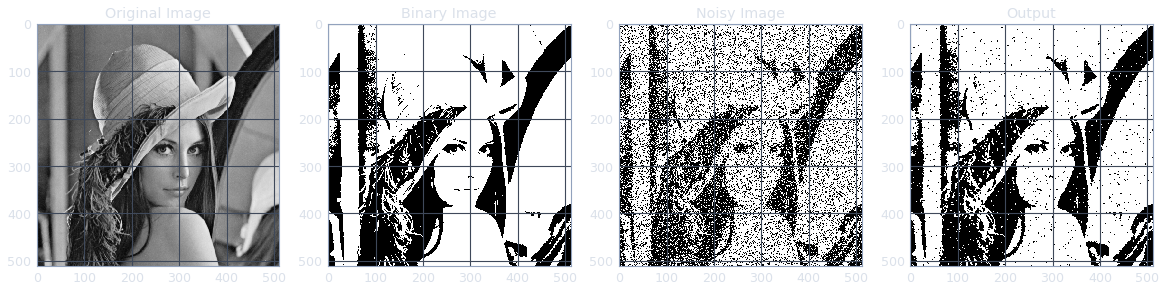

In [6]:
denoise = Denoise(alpha=1, beta=10)
output = denoise(noisy_image)

fig = plt.figure(figsize=(20, 15))
fig.add_subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')

fig.add_subplot(1, 4, 2)
plt.title("Binary Image")
plt.imshow(binary_image, cmap='gray')

fig.add_subplot(1, 4, 3)
plt.title("Noisy Image")
plt.imshow(noisy_image, cmap='gray')

fig.add_subplot(1, 4, 4)
plt.title("Output")
plt.imshow(output, cmap='gray')
